In [1]:
import mido
import numpy as np
import matplotlib.pyplot as plt
import PreProcessor as pp

In [2]:
dataset = pp.load_dataset("adl-piano-midi")
ClassicSongs = pp.files_to_songs(dataset["Classical"])

channel_to_ind, ind_to_channel, note_to_ind, ind_to_note, velocity_to_ind, ind_to_velocity, tick_to_ind, ind_to_tick = pp.dicts_from_songs(ClassicSongs,velocities_and_ticks=True)

n_Channels = len(channel_to_ind)
n_Notes = len(note_to_ind)
n_Velocities = len(velocity_to_ind)
n_Ticks = len(tick_to_ind)

print("Number of channels  :",n_Channels,"\nNumber of notes     :",n_Notes,"\nNumber of velocities:",n_Velocities,"\nNumber of time ticks:",n_Ticks)

Couldn't load : adl-piano-midi\Classical\Classical\Alexander Borodin\Nocturne.mid
Couldn't load : adl-piano-midi\Classical\Classical\Antonio Salieri\Invention.mid
Couldn't load : adl-piano-midi\Classical\Classical\Bela Bartok\Andante.mid
Couldn't load : adl-piano-midi\Classical\Classical\Bela Bartok\Romanian Folk Dance.mid
Couldn't load : adl-piano-midi\Classical\Classical\Claude Debussy\Clair De Lune.mid
Couldn't load : adl-piano-midi\Classical\Classical\Franz Schubert\Impromptu in C-Moll.mid
Couldn't load : adl-piano-midi\Classical\Classical\Franz Schubert\Impromptu in Ges-dur.mid
Couldn't load : adl-piano-midi\Classical\Classical\Franz Schubert\Trois Marches militaires 3.mid
Couldn't load : adl-piano-midi\Classical\Classical\Frederic Chopin\Prelude Op 28 No7.mid
Couldn't load : adl-piano-midi\Classical\Classical\Giacomo Puccini\O Mio Babibino Caro.mid
Couldn't load : adl-piano-midi\Classical\Classical\Jean-Baptiste Lully\Minuet.mid
Couldn't load : adl-piano-midi\Classical\Classical\

In [30]:
#AllChannels = np.array([])
AllNotes = np.array([])
AllVelocities = np.array([])
#AllTicks = np.array([])
for song in ClassicSongs.values():
#    AllChannels = np.append(AllChannels,song[:,0])
    AllNotes = np.append(AllNotes,song[:,1])
    AllVelocities = np.append(AllVelocities,song[:,2])
#    AllTicks = np.append(AllTicks,song[:,3])

#OneHotChannels = pp.one_hot_encode(channel_to_ind,AllChannels)
OneHotNotes = pp.one_hot_encode(note_to_ind,AllNotes)
OneHotVelocities = pp.one_hot_encode(velocity_to_ind,AllVelocities)
#OneHotTicks = pp.one_hot_encode(tick_to_ind,AllTicks)

In [31]:
seq_length = 25
n_batch = 100

#X_channels, y_channels = pp.label_sequences(OneHotChannels,seq_length,n_batch)
X_notes, y_notes = pp.label_sequences(OneHotNotes,seq_length,n_batch)
X_velocities, y_velocities = pp.label_sequences(OneHotVelocities,seq_length,n_batch)
#X_ticks, y_ticks = pp.label_sequences(OneHotTicks,seq_length,n_batch)
#print(X_channels.shape)
print(X_notes.shape)
print(X_velocities.shape)
#print(X_ticks.shape)

#X_train = np.concatenate([X_notes, X_velocities], axis=2) #np.concatenate([X_channels, X_notes, X_velocities, X_ticks], axis=2)
#y_train = np.concatenate([y_notes, y_velocities], axis=2) #np.concatenate([y_channels, y_notes, y_velocities, y_ticks], axis=2)
#print(X_train.shape)
#print(y_train.shape)

(85900, 25, 12)
(85900, 25, 105)
(85900, 25, 128)
(85900, 25, 1094)


In [10]:
from keras.models import Model
from tensorflow.keras.layers import Input, SimpleRNN, Dense, Lambda, Softmax, concatenate
from keras import optimizers

In [37]:
dim = 100
n_epochs = 5

# Define input layers for notes and velocities
input_notes = Input(shape=(None, n_Notes))
input_velocities = Input(shape=(None, n_Velocities))

# Define SimpleRNN layer
rnn_output = SimpleRNN(units=dim, return_sequences=True)(concatenate([input_notes, input_velocities]))

# Define Dense layer for each branch
dense_output = Dense(units=n_Notes+n_Velocities)(rnn_output)

# Use Lambda layer to split the output of Dense layer into two branches
notes_output = Lambda(lambda x: x[:, :, :n_Notes])(dense_output)
velocities_output = Lambda(lambda x: x[:, :, n_Notes:])(dense_output)

# Use Lambda layer to split the output of SimpleRNN into two branches
soft_notes = Softmax(name="soft_notes")(notes_output)
soft_velocities = Softmax(name="soft_velocities")(velocities_output)

# Define the model with inputs and outputs
model = Model(inputs=[input_notes, input_velocities], outputs=[soft_notes, soft_velocities])

model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, None, 105)]  0           []                               
                                                                                                  
 input_24 (InputLayer)          [(None, None, 128)]  0           []                               
                                                                                                  
 concatenate_8 (Concatenate)    (None, None, 233)    0           ['input_23[0][0]',               
                                                                  'input_24[0][0]']               
                                                                                                  
 simple_rnn_10 (SimpleRNN)      (None, None, 100)    33400       ['concatenate_8[0][0]']    

In [38]:
# Compile the model
losses = {
    'soft_notes': 'categorical_crossentropy',
    'soft_velocities': 'categorical_crossentropy'
}

# Define weights for each loss
loss_weights = {
    'soft_notes': 10.0,
    'soft_velocities': 1.0
}
model.compile(optimizer='adam', loss=losses, loss_weights=loss_weights, metrics=['accuracy'])
history = model.fit([X_notes, X_velocities], [y_notes, y_velocities], epochs=n_epochs, batch_size=n_batch)

Epoch 1/5
859/859 [==============================] - 28s 26ms/step - loss: 37.5300 - soft_notes_loss: 3.5017 - soft_velocities_loss: 2.5132 - soft_notes_accuracy: 0.1070 - soft_velocities_accuracy: 0.5524
Epoch 2/5
859/859 [==============================] - 22s 26ms/step - loss: 33.3413 - soft_notes_loss: 3.1173 - soft_velocities_loss: 2.1682 - soft_notes_accuracy: 0.1697 - soft_velocities_accuracy: 0.6108
Epoch 3/5
859/859 [==============================] - 22s 25ms/step - loss: 32.6135 - soft_notes_loss: 3.0527 - soft_velocities_loss: 2.0864 - soft_notes_accuracy: 0.1839 - soft_velocities_accuracy: 0.6140
Epoch 4/5
859/859 [==============================] - 22s 25ms/step - loss: 32.1287 - soft_notes_loss: 3.0112 - soft_velocities_loss: 2.0166 - soft_notes_accuracy: 0.1927 - soft_velocities_accuracy: 0.6154
Epoch 5/5
859/859 [==============================] - 22s 26ms/step - loss: 31.7724 - soft_notes_loss: 2.9812 - soft_velocities_loss: 1.9600 - soft_notes_accuracy: 0.1990 - soft_vel

(0.0, 1.0)

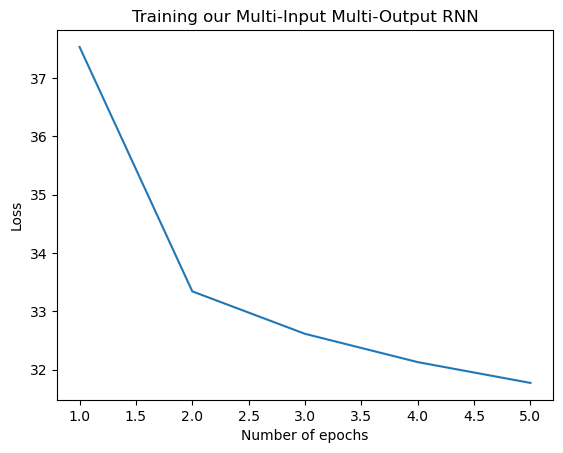

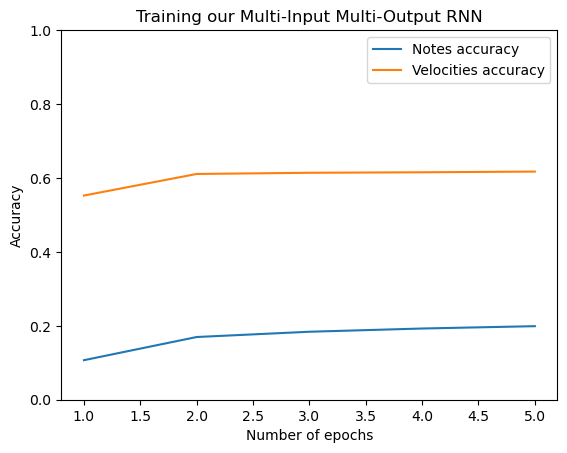

In [39]:
loss = history.history['loss']
notes_accuracy = history.history['soft_notes_accuracy']
velocities_accuracy = history.history['soft_velocities_accuracy']

x = range(1,len(loss)+1)
plt.figure()
plt.plot(x, loss)
plt.title("Training our Multi-Input Multi-Output RNN")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.figure()
plt.plot(x, notes_accuracy, label="Notes accuracy")
plt.plot(x, velocities_accuracy, label="Velocities accuracy")
plt.legend()
plt.title("Training our Multi-Input Multi-Output RNN")
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.ylim([0,1])